# [DL-MIPT-2024] Построение классификатора

# <a id="0">Содержание</a>

- <a href="#1">Описание задачи и данных</a>
- <a href="#2">Загрузка библиотек</a>  
- <a href="#3">Загрузка данных и их рассмотрение</a>  
- <a href="#4">Исследование классов</a>
    - <a href="#41">Распределение классов</a>
    - <a href="#42">Примеры изображений</a>
- <a href="#5">Создание модели</a>  
    - <a href="#51">Подготовка данных</a>  
    - <a href="#52">Разделение и трансформация данных</a>  
    - <a href="#53">Создание арзхитектуры модели</a>   
    - <a href="#54">Обучение модели</a>   
    - <a href="#55">Проверка модели на тестовых данных</a>  
    - <a href="#56">Сохранение предсказаний на тестовых данных<</a>   
- <a href="#6">Выводы</a>

# <a id="1">Описание задачи и данных</a>

**Описание задачи**

Это учебное соревнование в рамках курса “Глубокое обучение в науках о данных”. В нем вам предстоит построить модель, классифицирующую изображения с одеждой, построенную на датасете Fashion-MNIST. Подробнее о датасете можно узнать во вкладке Data. Задача будет считаться решенной, если в Public Leaderboard вы наберете score, который будет равен или больше 0.80. В качестве метрики используется accuracy. В день вы можете отправлять не более 20 решений (это ограничения платформы). Помните, что решения принимаются только в том формате, который представлен в файле sample_submission.csv.

**Описание данных**

Fashion-MNIST – аналог знаменитого датасета MNIST, который состоит не из рукописных символов, а из предметов одежды. Он был создан, чтобы актуализировать учебные задачи в компьютерном зрении и приблизить их к реальности.

Решение более сложной постановки этой задачи может использоваться, например, в маркетплейсах. Покупателю могут рекомендоваться товары по изображениям в соответствии с введённым описанием. Продавцу при загрузке изображений в карточку товара могут автоматически рекомендоваться теги и описание предмета одежды.

Каждое изображение представляет собой набор их 784 пикселей (28x28). Каждый пиксель принимает значение от 0 до 255, обозначая его цвет в черно-белой шкале. Обучающая выборка содержит 786 столбцов, где первый (label) – принадлежность изображения к классу, а последний – его уникальный номер (id). Остальные столбцы – пиксели изображения.
Проведите первичный анализ данных, чтобы определить наличие NaN значений.
Тестовая выборка (на основе которой должно быть получено исследование) содержит все те же столбцы, кроме label.

Расшифровка классов (label), к которым принадлежат изображения:

0. T-shirt/top – футболка
1. Trouser – брюки
2. Pullover – свитер
3. Dress – платье
4. Coat – пальто
5. Sandal – сандалия
6. Shirt – рубашка
7. Sneaker – кроссовок
8. Bag – сумка
9. Ankle boot – сапог

Структура данных:

- fmnist_train.csv – обучающая выборка
- fmnist_test.csv – тестовая выборка (на которой должно быть получено предсказание)
- sample_submission.csv – пример решения

# <a id="2">Загрузка библиотек</a>  

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset, random_split
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings

In [2]:
warnings.filterwarnings('ignore')

# <a id="3">Загрузка данных</a>  

Загрузим изначальные данные для рассмотрения

In [5]:
# Загрузим датасеты
df_train = pd.read_csv('data/dl-mfti-2024-classificator/fashion-mnist_train.csv')
df_test = pd.read_csv('data/dl-mfti-2024-classificator/fashion-mnist_test.csv')
df_example = pd.read_csv('data/dl-mfti-2024-classificator/sample_submission.csv')

In [6]:
# Посмотрим первые строки датасета
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Посмотрим информацию о датасете
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [8]:
# Посмотрим статистики датасета
df_train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


В тренировочном датасете дано 60 тыс. строк с информацией о рисунках размером 28*28 пикселей. Также имеется столбец `label` с классом одежды

In [9]:
# Посмотрим первые строки датасета
df_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Посмотрим информацию о датасете
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [11]:
# Посмотрим статистики датасета
df_test.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,4.500000,0.000400,0.010300,0.052100,0.077000,0.208600,0.349200,0.826700,2.321200,5.457800,...,34.320800,23.071900,16.432000,17.870600,22.860000,17.790200,8.353500,2.541600,0.629500,0.06560
std,2.872425,0.024493,0.525187,2.494315,2.208882,4.669183,5.657849,8.591731,15.031508,23.359019,...,57.888679,49.049749,42.159665,44.140552,51.706601,45.128107,28.765769,16.417363,7.462533,1.93403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,2.000000,45.000000,218.000000,185.000000,227.000000,223.000000,247.000000,218.000000,244.000000,...,254.000000,252.000000,255.000000,255.000000,255.000000,255.000000,240.000000,225.000000,205.000000,107.00000


В тестовом датасете дано 10 тыс. строк. Структура данных такая же, как в тренировочном датасете

In [12]:
# Посмотрим первые строки датасета
df_example.head()

,Id,Category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [13]:
# Посмотрим информацию о датасете
df_example.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        10000 non-null  int64
 1   Category  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


Итоговый датасет, который необходимо направить на проверку должен состоять из столбwов `Id` с номером строки из тестового датасета и `Category` с предсказанными классами

# <a id="4">Исследование данных</a>  

## <a id="41">Распределение классов</a>

Давайте рассмотрим распределение классов в тренировочном датасете

In [14]:
# Создадим словарь с классами одежды
labels = {0 : "футболка", 1: "брюки", 2: "свитер", 3: "платье", 4: "пальто",
          5: "сандалия", 6: "рубашка", 7: "кроссовок", 8: "сумка", 9: "сапог"}

def get_classes_distribution(data):
    """
    Выводит распределение классов в данных.

    Аргументы:
    data -- DataFrame, содержащий столбец "label" с метками классов.

    Возвращает:
    Ничего не возвращает, просто выводит распределение классов на экран.
    """
    
    # Посчитаем количество объектов для каждого класса
    label_counts = data["label"].value_counts()

    # Посчитаем общее количество строк в данных
    total_samples = len(data)

    # Выведем количество объектов для каждого класса
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

# Применим функцию
get_classes_distribution(df_train)

свитер              :   6000 or 10.0%
сапог               :   6000 or 10.0%
рубашка             :   6000 or 10.0%
футболка            :   6000 or 10.0%
платье              :   6000 or 10.0%
пальто              :   6000 or 10.0%
сандалия            :   6000 or 10.0%
сумка               :   6000 or 10.0%
кроссовок           :   6000 or 10.0%
брюки               :   6000 or 10.0%


Видим, что для каждого класса ровно по 6 тыс. объектов или по 10%. Теперь посмотрим какое распределение классов в тестовых данных

In [15]:
# Применим функцию
get_classes_distribution(df_test)

футболка            :   1000 or 10.0%
брюки               :   1000 or 10.0%
свитер              :   1000 or 10.0%
платье              :   1000 or 10.0%
сумка               :   1000 or 10.0%
рубашка             :   1000 or 10.0%
сандалия            :   1000 or 10.0%
пальто              :   1000 or 10.0%
кроссовок           :   1000 or 10.0%
сапог               :   1000 or 10.0%


## <a id="42">Примеры изображений</a>

Рассмотрим несколько примеров изображений из тренировочного датасета. Для этого создадим функцию для формирования изображений

In [16]:
def sample_images_data(data):
    """
    Выбирает некоторые образцы из данных для визуализации изображений

    Аргументы:
    data -- DataFrame, содержащий столбец "label" с метками классов.

    Возвращает:
    sample_images -- список массивов изображений для визуализации.
    sample_labels -- список меток соответствующих изображений.
    """

    # Пустой список для сбора образцов изоюражений
    sample_images = []
    sample_labels = []

    # Перебираем ключи словаря меток, определенного в предыдущей ячейке
    for k in labels.keys():
        # Получаем четыре образца для каждой категории
        samples = data[data["label"] == k].tail(4)
        # Добавляем образцы в список образцов
        for j, s in enumerate(samples.values):
            # Первый столбец содержит метки, поэтому индекс должен начинаться с 1
            img = np.array(samples.iloc[j, 1:]).reshape(28,28)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Общее количество образцов изображений для визуализации:", len(sample_images))
    return sample_images, sample_labels

In [17]:
# Используем функцию для выбора объектов
train_sample_images, train_sample_labels = sample_images_data(df_train)

Общее количество образцов изображений для визуализации: 40


Теперь отобразим выбранные изображения

In [18]:
def plot_sample_images(data_sample_images, data_sample_labels, cmap="Blues"):
    """
    Визуализирует выбранные образцы изображений.

    Аргументы:
    data_sample_images -- список массивов изображений для визуализации.
    data_sample_labels -- список меток соответствующих изображений.
    cmap -- строка, задающая цветовую карту для визуализации (по умолчанию "Blues").

    Возвращает:
    Ничего не возвращает, просто отображает изображения.
    """
    
    # Создаем график для отображения образцов изображений
    f, ax = plt.subplots(5, 8, figsize=(16, 10))

    # Перебираем образцы изображений для визуализации
    for i, img in enumerate(data_sample_images):
        ax[i // 8, i % 8].imshow(img, cmap=cmap)
        ax[i // 8, i % 8].axis('off')
        ax[i // 8, i % 8].set_title(labels[data_sample_labels[i]])
    plt.show()

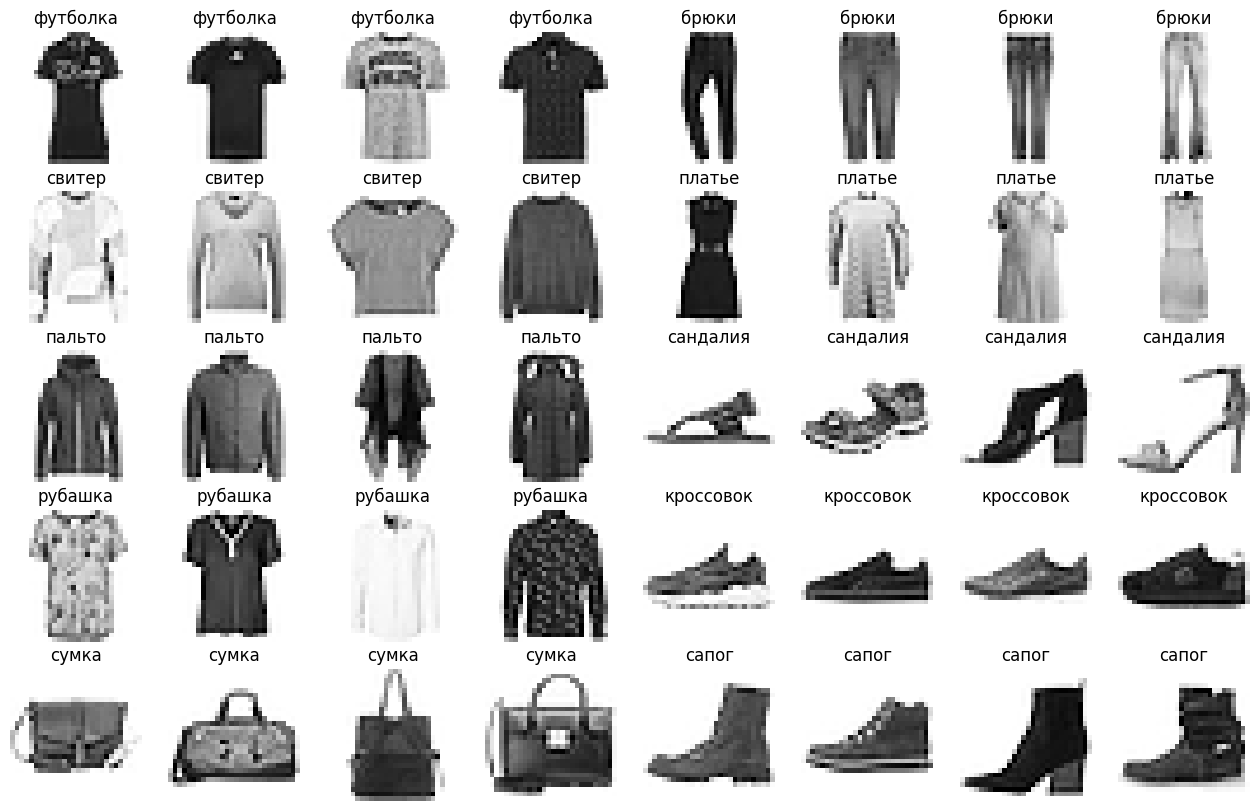

In [19]:
# отобразим выбранные образцы
plot_sample_images(train_sample_images,train_sample_labels, "Greys")

Теперь отобразим изображения из тестовой выборки

Общее количество образцов изображений для визуализации: 40


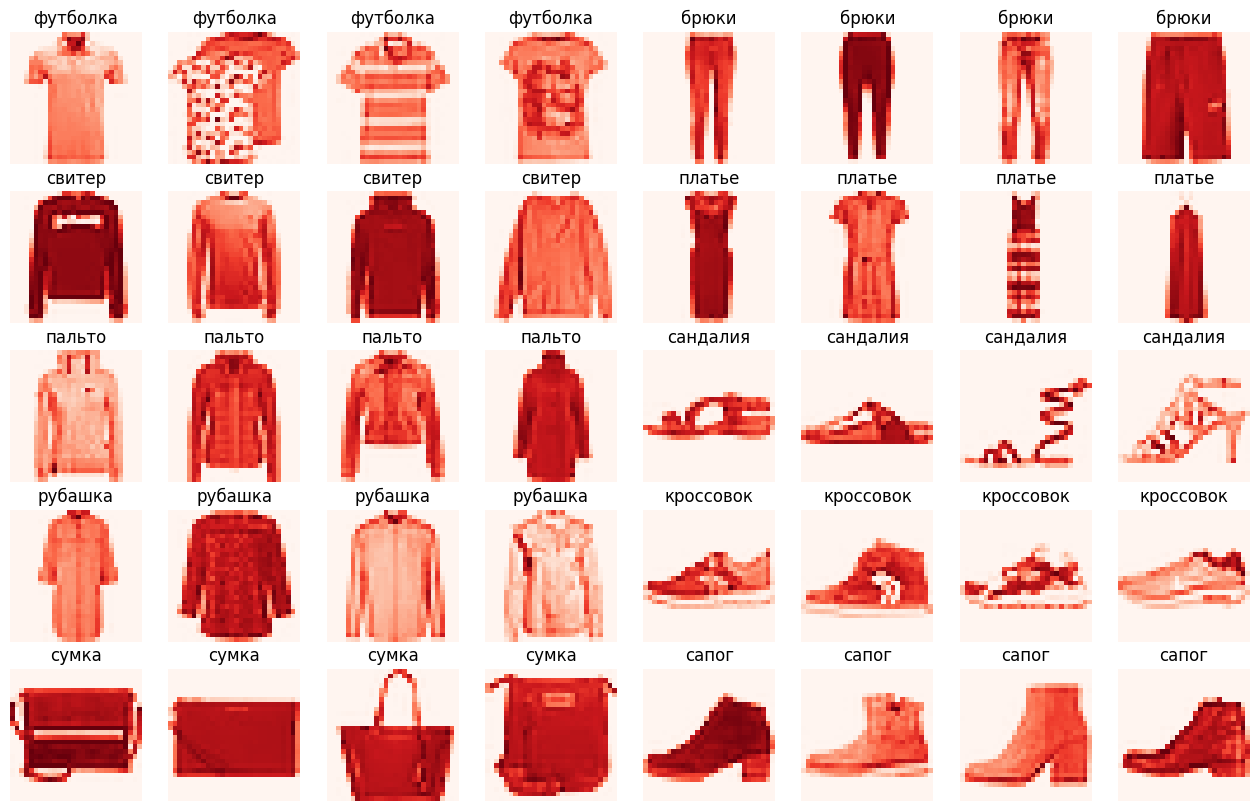

In [20]:
# Используем функцию для выбора объектов
test_sample_images, test_sample_labels = sample_images_data(df_test)
# отобразим выбранные образцы
plot_sample_images(test_sample_images,test_sample_labels, "Reds")

# <a id="5">Создание модели</a>

А теперь создадим модель нейронной сети с помощью библиотеки torch

## <a id="51">Подготовка данных</a>

Проверим обучающий датасет на пропуски

In [21]:
# Проверка на наличие NaN значений в датасете
nan_info = df_train.isna().sum()
nan_info[nan_info > 0]

Series([], dtype: int64)

Пропусков нет

In [22]:
# Проверка на дубликаты
duplicates = df_train[df_train.duplicated()]

if duplicates.empty:
    print("Дубликаты отсутствуют.")
else:
    print("Найдены дубликаты.")

duplicates

Найдены дубликаты.


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
6293,3,0,0,0,0,0,0,0,0,57,...,22,0,0,0,0,0,0,0,0,0
11845,0,0,0,0,0,2,0,0,0,0,...,34,26,22,26,8,0,2,0,0,0
20114,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21571,0,0,0,0,0,0,0,0,0,24,...,136,99,18,0,0,0,0,0,0,0
22159,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23718,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24228,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24443,2,0,0,0,0,0,0,0,0,0,...,108,97,106,62,0,0,0,0,0,0
28184,3,0,0,0,0,0,0,0,0,0,...,48,24,0,0,0,0,0,0,0,0
28635,2,0,0,0,0,0,0,0,0,0,...,0,0,0,98,128,88,0,0,0,0


Обнаружено в тренировочном датасете 43 дубликата. Удалим их

In [23]:
# Удалим дубликаты
df_train = df_train.drop_duplicates()

## <a id="52">Разделение и трансформация данных</a>

Разделим тренировочную выборку на метки и признаки. Далее обработаем признаки с помощью модуля `transforms`, а также выделим валидационную выборку

In [24]:
# Выделение меток и признаков
labels = torch.tensor(df_train['label'].values, dtype=torch.long)
features = df_train.drop(['label'], axis=1).values.reshape(-1, 28, 28).astype('float32')
features = features / 255.0

In [25]:
# Определение трансформаций для тренировочного набора
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Преобразование массива в PIL Image для аугментации
    transforms.RandomHorizontalFlip(),  # Рандомное горизонтальное отражение
    transforms.RandomRotation(10),  # Рандомные повороты на ±10 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Изменение яркости и контраста
    transforms.ToTensor(),  # Преобразование в тензор
])

In [26]:
# Трансформации для валидационного набора 
val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [27]:
# Создание TensorDataset
dataset = TensorDataset(torch.tensor(features, dtype=torch.float32), labels)

In [31]:
# labels содержит метки классов для каждого элемента в наборе данных
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,  # Процент данных в валидационном наборе
    stratify=labels,  # Стратификация по меткам классов
    random_state=42 
)

# Создаем поднаборы данных для обучения и валидации
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

In [32]:
# Функции для применения трансформаций к каждому элементу батча
def train_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack([train_transforms(image.numpy()) for image in images])
    return images, torch.tensor(labels)

def val_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack([val_transforms(image.numpy()) for image in images])
    return images, torch.tensor(labels)

In [33]:
# Создание DataLoader с применением трансформаций
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=train_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=val_collate_fn)

## <a id="53">Создание архитектуры модели</a>

**Архитектура FashionMNISTModel**

Модель `FashionMNISTModel` является сверточной нейронной сетью (CNN), разработанной для классификации изображений одежды в предоставленном наборе данных. Вот общий обзор архитектуры:

**Сверточные блоки**

Сеть содержит три основных блока сверточных слоев:

1. **Первый блок**:
   - `Conv2d` с 64 фильтрами размером 3x3 и padding 1, сохраняющий размерность изображения.
   - `BatchNorm2d` для нормализации активаций и ускорения сходимости.
   - `PReLU` как функция активации, позволяющая адаптивно изменять параметры при обучении.
   - Дополнительные сверточные слои для углубления извлечения признаков.
   - `MaxPool2d` для уменьшения пространственных размеров и получения более абстрактных признаков.

2. **Второй блок**:
   - Повторение структуры первого блока, но с увеличением количества фильтров до 128.

3. **Третий блок**:
   - Снова увеличение количества фильтров до 256.
   - Использование residual connections для улучшения потока градиентов и предотвращения проблемы исчезающего градиента при глубоком обучении.

**Глобальный усредняющий пулинг (Global Average Pooling)**

- `AdaptiveAvgPool2d` преобразует карту признаков каждого класса в единственное значение, что помогает уменьшить общее количество параметров и контролировать переобучение.

**Классификационные слои**

- Полносвязные слои (Fully Connected Layers), которые классифицируют изображения на основе извлеченных признаков.
- Прореживание (`Dropout`) используется для уменьшения переобучения путем случайного исключения нейронов во время обучения.
- Завершающий полносвязный слой выводит вероятности принадлежности к одному из 10 классов.

**Прямое распространение (Forward Pass)**

- В методе `forward` данные последовательно проходят через сверточные блоки, пулинг, и классификационные слои, результатом чего является окончательная классификация изображения.

In [34]:
# Определение архитектуры сети
class FashionMNISTModel(nn.Module):
    def __init__(self):
        super(FashionMNISTModel, self).__init__()
        # Определение сверточных слоев сети
        self.features = nn.Sequential(
            # Первый блок сверточных слоев
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # Сверточный слой с 64 фильтрами размером 3x3
            nn.BatchNorm2d(64),  # Нормализация данных для улучшения обучения
            nn.PReLU(num_parameters=64),  # Функция активации PReLU (Parametric ReLU)
            nn.Conv2d(64, 64, kernel_size=1, padding=0),  # Промежуточный сверточный слой для уменьшения размерности
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Дополнительный сверточный слой для углубления признаков
            nn.PReLU(num_parameters=64),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Максимальный пулинг для уменьшения пространственного размера
            # Второй блок сверточных слоев
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.PReLU(num_parameters=128),
            nn.Conv2d(128, 128, kernel_size=1, padding=0),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.PReLU(num_parameters=128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Третий блок сверточных слоев с использованием residual connection
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.PReLU(num_parameters=256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.PReLU(num_parameters=256),
            nn.Conv2d(256, 256, kernel_size=1, padding=0),
            nn.PReLU(num_parameters=256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Введение Global Average Pooling для агрегации признаков
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Определение полносвязных слоев для классификации
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Прореживание для предотвращения переобучения
            nn.Linear(256, 512),  # Полносвязный слой
            nn.PReLU(num_parameters=512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.PReLU(num_parameters=256),
            nn.Linear(256, 10)  # Выходной слой для 10 классов
        )

    def forward(self, x):
        x = self.features(x)  # Применение сверточных слоев
        x = self.global_avg_pool(x)  # Применение глобального усредняющего пулинга
        x = x.view(x.size(0), -1)  # Преобразование тензора для подачи в полносвязные слои
        x = self.classifier(x)  # Применение полносвязных слоев
        return x  # Возвращение результата

In [35]:
# Создание экземпляра модели и перемещение на доступное устройство (GPU если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionMNISTModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam (model.parameters(), lr=0.001)

## <a id="54">Обучение модели</a>

Создадим функцию для обучения модели с проверкой на валидационных данных

In [42]:
best_accuracy = 0.0  # Инициализация переменной для хранения лучшей точности
best_model_state = None  # Переменная для сохранения состояния лучшей модели

def train_model(epochs, train_loader, val_loader, model, criterion, optimizer, device):
    global best_accuracy 
    global best_model_state 
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            correct, total = 0, 0
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = correct / total
            if epoch % 2 == 0:
                print(f'Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}')
            
            # Сохранение модели, если достигнута лучшая точность
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = model.state_dict()  # Сохранение состояния модели

    # Возвращение состояния лучшей модели после окончания всех эпох
    return best_model_state

Запускаем обучение с помощью функции

In [51]:
# обучим модель с помощью функции
best_model_state = train_model(60, train_loader, val_loader, model, criterion, optimizer, device)

Epoch 1, Loss: 0.19055329263210297, Accuracy: 0.9405436957971981
Epoch 3, Loss: 0.017691409215331078, Accuracy: 0.9398765843895931
Epoch 5, Loss: 0.031182343140244484, Accuracy: 0.9328719146097398
Epoch 7, Loss: 0.026040000841021538, Accuracy: 0.935790527018012
Epoch 9, Loss: 0.016834162175655365, Accuracy: 0.9338725817211474
Epoch 11, Loss: 0.05864889919757843, Accuracy: 0.9373749166110741
Epoch 13, Loss: 0.009899290278553963, Accuracy: 0.9377918612408273
Epoch 15, Loss: 0.09058120846748352, Accuracy: 0.9377918612408273
Epoch 17, Loss: 0.01896144635975361, Accuracy: 0.9409606404269513
Epoch 19, Loss: 0.0597861111164093, Accuracy: 0.9371247498332221
Epoch 21, Loss: 0.007901936769485474, Accuracy: 0.9375416944629753
Epoch 23, Loss: 0.002001814544200897, Accuracy: 0.9422948632421615
Epoch 25, Loss: 0.008160634897649288, Accuracy: 0.9370413609072715
Epoch 27, Loss: 0.02464987151324749, Accuracy: 0.939209472981988
Epoch 29, Loss: 0.09391757845878601, Accuracy: 0.9367911941294196
Epoch 31, 

In [52]:
# посмотрим наилучшую точность
best_accuracy

0.9422948632421615

Итого обучил модель на 120 эпохах. Но данные проверял на `best_model_state`

## <a id="55">Проверка модели на тестовых данных</a>

Также преобразуем данные в тестовой выборке с помощью `transform`

In [53]:
# Преобразование данных в формат, подходящий для модели
labels_test = df_test['label'].values
features_test = df_test.drop(['label'], axis=1).values.reshape(-1, 28, 28).astype('float32')
features_test = features_test / 255.0

In [54]:
# Трансформация данных
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

# Преобразование тестовых данных в тензоры
test_tensors = torch.stack([transform(image) for image in features_test])
labels_tensors = torch.tensor(labels_test)

# Создание тестового DataLoader
test_dataset = TensorDataset(test_tensors, labels_tensors)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Проверим точность модели на тестовой выборке

In [55]:
model.load_state_dict(best_model_state)
# Предсказание модели
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Вычисление точности
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9406


## <a id="56">Сохранение предсказаний на тестовых данных</a>

In [56]:
# Получение индексов из df_test как уникальные ID
ids = df_test.index

# Создание DataFrame из индексов и предсказанных меток
results_df = pd.DataFrame({
    'Id': ids,
    'Category': predicted_labels
})

# Просмотр итогового датасета
print(results_df.head())

   Id  Category
0   0         0
1   1         1
2   2         2
3   3         2
4   4         3


In [57]:
# Сохранение итогового датасета в CSV файл
results_df.to_csv('data/test_predictions.csv', index=False)

# <a id="6">Выводы</a>

По итогу, применив полученные знания, постарался комплексно подойти к решению задачи классификации изображений с использованием сверточных нейронных сетей в PyTorch. Были выполнены этапы от загрузки и первичной обработки данных до моделирования и оценки результатов. Наилучший результат получил с точностью - 0,9406 на описанной выше модели.